In [85]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [86]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="Root@123",
)
cursor = conn.cursor()

In [87]:
# Define a function to execute SQL queries and return results as a DataFrame
def execute_query(query):
    with conn.cursor() as cursor:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        return pd.DataFrame(cursor.fetchall(), columns=columns)


query = """
SELECT * FROM public.xdr_data
"""
# Execute query and load data into DataFrame
df = execute_query(query)
# Check the first few rows of the DataFrame
print(df.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [88]:
import pandas as pd

# Assuming df is your DataFrame containing the dataset
# Replace missing values with the mean or mode of the corresponding variable
df["TCP DL Retrans. Vol (Bytes)"] = df["TCP DL Retrans. Vol (Bytes)"].fillna(
    df["TCP DL Retrans. Vol (Bytes)"].mean()
)
df["Avg RTT DL (ms)"] = df["Avg RTT DL (ms)"].fillna(df["Avg RTT DL (ms)"].mean())
df["Avg Bearer TP DL (kbps)"] = df["Avg Bearer TP DL (kbps)"].fillna(
    df["Avg Bearer TP DL (kbps)"].mean()
)
df["Handset Type"] = df["Handset Type"].fillna(df["Handset Type"].mode()[0])

# Aggregate per customer information
customer_info = (
    df.groupby("Bearer Id")
    .agg(
        {
            "TCP DL Retrans. Vol (Bytes)": "mean",
            "Avg RTT DL (ms)": "mean",
            "Handset Type": lambda x: x.mode()[0],
            "Avg Bearer TP DL (kbps)": "mean",
        }
    )
    .reset_index()
)

# Now you have the aggregated information per customer

In [89]:
# Compute statistics for TCP values
tcp_stats = df["TCP DL Retrans. Vol (Bytes)"].describe()
# Get top 10 TCP values
top_tcp_values = df["TCP DL Retrans. Vol (Bytes)"].value_counts().head(10)
# Get bottom 10 TCP values
bottom_tcp_values = df["TCP DL Retrans. Vol (Bytes)"].value_counts().tail(10)

# Compute statistics for RTT values
rtt_stats = df["Avg RTT DL (ms)"].describe()
# Get top 10 RTT values
top_rtt_values = df["Avg RTT DL (ms)"].value_counts().head(10)
# Get bottom 10 RTT values
bottom_rtt_values = df["Avg RTT DL (ms)"].value_counts().tail(10)

# Compute statistics for Throughput values
throughput_stats = df["Avg Bearer TP DL (kbps)"].describe()
# Get top 10 Throughput values
top_throughput_values = df["Avg Bearer TP DL (kbps)"].value_counts().head(10)
# Get bottom 10 Throughput values
bottom_throughput_values = df["Avg Bearer TP DL (kbps)"].value_counts().tail(10)

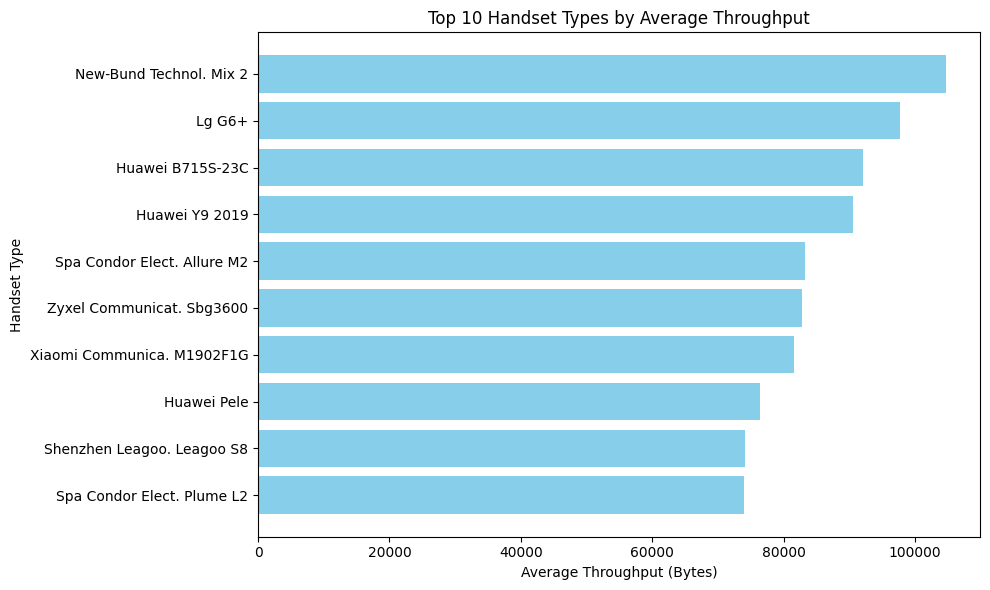

In [90]:
# Get the top and bottom 10 handset types based on average throughput
top_10_handsets = throughput_distribution.nlargest(10)
bottom_10_handsets = throughput_distribution.nsmallest(10)

# Plotting the top 10 handset types
plt.figure(figsize=(10, 6))
plt.barh(top_10_handsets.index, top_10_handsets.values, color="skyblue")
plt.xlabel("Average Throughput (Bytes)")
plt.ylabel("Handset Type")
plt.title("Top 10 Handset Types by Average Throughput")
plt.gca().invert_yaxis()  # Invert y-axis to display highest throughput at the top
plt.tight_layout()
plt.show()

In [92]:
# Select relevant numeric columns for clustering
numeric_columns = [
    "Avg Bearer TP DL (kbps)",
    "Avg RTT DL (ms)",
    "TCP DL Retrans. Vol (Bytes)",
]
clustering_data = df[numeric_columns].copy()  # Make a copy of the DataFrame

# Drop any rows with missing values
clustering_data.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(scaled_data)

# Brief description of each cluster
cluster_description = df.groupby("cluster")[numeric_columns].mean()
print(cluster_description.to_string())

         Avg Bearer TP DL (kbps)  Avg RTT DL (ms)  TCP DL Retrans. Vol (Bytes)
cluster                                                                       
0                   13221.359389       101.228579                 1.648984e+07
1                   63358.653386       111.366534                 2.601163e+09
2                    3330.202532     16335.822785                 7.158202e+06
